# **Homework 4:** Automatic Differentiation and Neural Networks (solutions)

## Overview

In this homework we will build a tiny neural network libarary from scratch and start on an implementation of automatic differentiation!

In [ ]:
# Uncomment and run if using Colab!

#import urllib.request
#remote_url = 'https://gist.githubusercontent.com/gabehope/cb9e69f642104f107f25826a0931629a/raw/163f9cf5325db28826f4103d0f168702c77dfca1/hw4_support.py'
#with urllib.request.urlopen(remote_url) as remote, open('hw4_support.py', 'w') as local:
#  [local.write(str(line, encoding='utf-8')) for line in remote]

In [1]:
# Run me first!
from hw4_support import *

#### Python features
This homework makes use of a few fancy features in Python that are worth knowing about if you are unfamiliar.
- [Variable length arguments](https://book.pythontips.com/en/latest/args_and_kwargs.html) (e.g. `*args`)
- [List comprehensions](https://book.pythontips.com/en/latest/comprehensions.html#list-comprehensions) (e.g. `[a**2 for a in range(5)]`)
- [Magic methods](https://rszalski.github.io/magicmethods/) (e.g. `__add__`)


## Part 1: Autograd

In this homework we will be using a special version of Numpy from a package called `Autograd`. Assuming it is installed (`pip install autograd`), we can import it as follows:

In [2]:
import autograd.numpy as np

This special version of Numpy behaives exactly like normal numpy. We can create and do calculations with arrays just like we would before:

In [3]:
x = np.array([3., 2., 1])
print('x:\t', x)
print('x^2:\t', x ** 2)
print('sum(x):\t', np.sum(x))

x:	 [3. 2. 1.]
x^2:	 [9. 4. 1.]
sum(x):	 6.0


However, Autograd also has a very important trick up its sleeve: it can take derivatives (and gradients) for us! This functionality can be accessed through the `grad` function. Let's start by seeing it in action with a very simple example, where we know the correct answer. The square function and its derivative can be written as:

$f(x) = x^2, \quad f'(x) = 2x$

The following code uses Autograd to compute this derivative automatically:

In [4]:
from autograd import grad

# Define a function
def f(x):
    return x ** 2

# Use 'grad' to compute the derivative function
f_prime = grad(f)

# Verify that we get the correct answer
x = 5.
print('x:\t', x)
print('f(x):\t', f(x))
print("f'(x):\t", f_prime(x))


x:	 5.0
f(x):	 25.0
f'(x):	 10.0


We can start to see how `grad` operates. `grad` takes as input a function (e.g. $f(x)$) and returns a new function that computes the derivative of $f$ at $x$. ($f'(x)$). So:

$\text{grad}(f) \longrightarrow f'$

#### **Q1:** Trying out `autograd`

Define the following function in python:

$f(x) = \log(\sin(x^3) + 3 x)$

Use `grad` to compute the derivative of $f$ at $1.5$ (i.e. compute $f'(1.5)$)

#### Answer

In [7]:
def f(x):
    return np.log(np.sin(x ** 3) + 3 * x)

answer = grad(f)(1.5)
print("f'(1.5)=", answer)

f'(1.5)= -0.8356083737326538


As the name would imply, `grad` can more generally be used to compute the *gradient* of a function of the form $f(\mathbf{x}): \mathbb{R}^d\rightarrow \mathbb{R}$. Remember that for a function that takes in a vector and outputs a scalar, the gradient is vector of all partial derivatives of the output with respect to each input. For example, consider a function that gives the square of the 2-norm of a vector:

$f(\mathbf{x}) = ||\mathbf{x}||^2_2 = \mathbf{x}^T\mathbf{x} = \sum_{i=1}^d x_i^2$

*Think about why these expressions are equivalent!*

As we've seen, the gradient of this function can be written as:

$\nabla f(\mathbf{x}) = 2\mathbf{x} = \begin{bmatrix}2x_1 \\ 2x_2 \\ \vdots \\ 2x_d \end{bmatrix}$

Let's see what Autograd gives us in this case:

In [8]:
# Define a function
def f(x):
    return np.sum(x ** 2)

# Use 'grad' to compute the derivative function
grad_f = grad(f)

# Verify that we get the correct answer
x = np.array([1., 2., 3])
print('x:\t', x)
print('f(x):\t', f(x))
print("f'(x):\t", grad_f(x))

x:	 [1. 2. 3.]
f(x):	 14.0
f'(x):	 [2. 4. 6.]


We see that the gradient has the same shape as the input. So the gradient function is of the form: $\mathbb{R}^d \rightarrow \mathbb{R}^d$

This makes sense as the gradient should have exactly one partial derivative for each entry in the input to the function. As discussed, this even extends beyond vectors! We could have a function that takes in any datastructure and computes the set of partial derivatives with respect to each entry.

#### **Q2:** More complex `autograd`

Write a function that takes a `list` of vectors and computes the sum of the squared 2-norm for each vector. That is:

$f([\mathbf{a}, \mathbf{b}, \mathbf{c}...]) = ||\mathbf{a}||^2 + ||\mathbf{b}||^2 + ||\mathbf{c}||^2+...$

*Recall from above how we can compute each term in this sum!*

Then use `grad` to compute the gradient of this function with respect to the given input.

In [9]:
# Define a function
def f(x):
    '''
    Compute the sum of squared 2-norms for a list of vectors

    Args:
        x (list of arrays): A list of 1-dimensional arrays
    Returns:
        output (float): The result
    '''
    return np.sum([np.sum(xi ** 2) for xi in x])

# Use 'grad' to compute the derivative function
grad_f = grad(f)

# Verify that we get the correct answer
x = [np.array([1., 2., 3]), np.array([7., 2.]), np.array([6.])]
print('x:\t', x)
print('f(x):\t', f(x))
print("f'(x):\t", grad_f(x))

x:	 [array([1., 2., 3.]), array([7., 2.]), array([6.])]
f(x):	 103.0
f'(x):	 [array([2., 4., 6.]), array([14.,  4.]), array([12.])]


A useful argument that we can give to `grad` is `argnum`. If our function takes more than one argument `argnum` lets us specify which one to take the gradient with respect to. For example, if we have the function:

$f(x, y) = x^2y$

Then:

$f'_x(x,y)=2xy, \quad f'_y(x, y)=x^2$

In [10]:
def f(x, y):
    return x ** 2 * y

print('f(3, 5) = ', f(3., 5.))

df_dx = grad(f, argnum=0)(3., 5.)
df_dy = grad(f, argnum=1)(3., 5.)

print('df_dx = ', df_dx)
print('df_dy = ', df_dy)

f(3, 5) =  45.0
df_dx =  30.0
df_dy =  9.0


Now that we have everything we need to apply automatic differentiation to train a neural network!

Before we do that though, let's try out our automatic differentiation for logistic regression. Below is a slight modification of LogisticRegression implementation we saw in the last homework.

In [98]:

def sigmoid(x):
    # Computes the sigmoid function
    return 1. / (1. + np.exp(-x))

class LogisticRegression:
    def __init__(self, dims):
        '''
        Args:
            dims (int): d, the dimension of each input
        '''
        self.weights = np.zeros((dims + 1, 1))

    def prediction_function(self, X, w):
        '''
        Get the result of our base function for prediction (i.e. x^t w)

        Args:
            X (array): An N x d matrix of observations.
            w (array): A (d+1) x 1 vector of weights.
        Returns:
            pred (array): A length N vector of f(X).
        '''
        X = np.pad(X, ((0,0), (0,1)), constant_values=1., mode='constant')
        return np.dot(X, w)

    def predict(self, X):
        '''
        Predict labels given a set of inputs.

        Args:
            X (array): An N x d matrix of observations.
        Returns:
            pred (array): An N x 1 column vector of predictions in {0, 1}
        '''
        return (self.prediction_function(X, self.weights) > 0)

    def predict_probability(self, X):
        '''
        Predict the probability of each class given a set of inputs

        Args:
            X (array): An N x d matrix of observations.
        Returns:
            probs (array): An N x 1 column vector of predicted class probabilities
        '''
        return sigmoid(self.prediction_function(X, self.weights))

    def accuracy(self, X, y):
        '''
        Compute the accuracy of the model's predictions on a dataset

        Args:
            X (array): An N x d matrix of observations.
            y (array): A length N vector of labels.
        Returns:
            acc (float): The accuracy of the classifier
        '''
        y = y.reshape((-1, 1))
        return (self.predict(X) == y).mean()

    def nll(self, X, y, w=None):
        '''
        Compute the negative log-likelihood loss.

        Args:
            X (array): An N x d matrix of observations.
            y (array): A length N vector of labels.
            w (array, optional): A (d+1) x 1 matrix of weights.
        Returns:
            nll (float): The NLL loss
        '''
        if w is None:
            w = self.weights

        y = y.reshape((-1, 1))
        xw = self.prediction_function(X, w)
        py = sigmoid((2 * y - 1) * xw)
        return -(np.log(py)).sum()

    def nll_gradient(self, X, y):
        '''
        Compute the gradient of the negative log-likelihood loss.

        Args:
            X (array): An N x d matrix of observations.
            y (array): A length N vector of labels.
        Returns:
            grad (array): A length (d + 1) vector with the gradient
        '''
        y = y.reshape((-1, 1))
        xw = self.prediction_function(X, self.weights)
        py = sigmoid((2 * y - 1) * xw)
        grad = ((1 - py) * (2 * y - 1)).reshape((-1, 1)) * np.pad(X, [(0,0), (0,1)], constant_values=1., mode='constant')
        return -np.sum(grad, axis=0)

    def nll_and_grad_no_autodiff(self, X, y):
        # Compute nll_and_grad without automatic diferentiation
        return self.nll(X, y), self.nll_gradient(X, y)


#### **Q3:** Logistic regression using `autograd`
Write the method `nll_and_grad` for the LogisticRegression class using the `grad` function from Autograd. Verify that it gives a similar answer to `nll_and_grad_no_autodiff`.

***Hint:** Note that the `nll` function can optionally take in the parameters. You can use this functionality and the `argnum` argument of `grad` in your answer. You can assume that `self` refers to the model object, so you can access the weights via `self.weights`*

In [99]:
from autograd import grad

def nll_and_grad(self, X, y):
    loss = self.nll(X, y)
    grads = grad(self.nll, argnum=2)(X, y, self.weights)
    return loss, grads

LogisticRegression.nll_and_grad = nll_and_grad

This implementation quite inefficient (we'll fix this in the future!), so we'll test our model on a very small dataset.

Loss 23.68, accuracy: 0.87: 100%|██████████| 250/250 [00:00<00:00, 1734.69it/s]

Model accuracy: 0.870


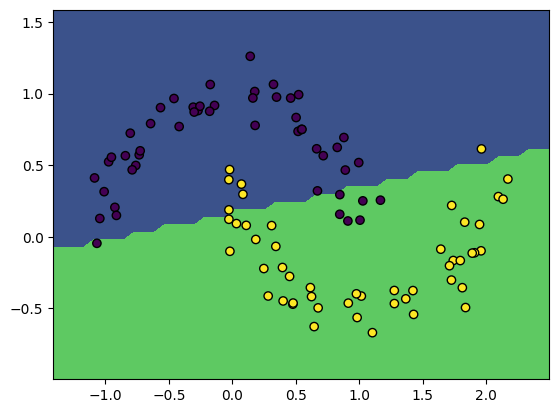

In [100]:
X, y = make_moons(100, noise=0.1)
model = LogisticRegression(2)
gradient_descent(model, X, y, lr=3e-2, steps=250)

print('Model accuracy: %.3f' % model.accuracy(X, y))
plot_boundary(model, X, y)

## Part 2: Feature transforms

Recall that in class we dicussed *feature transforms* an easy way to get more expressive models, using our linear model tools. Here we'll try applying some basic feature transforms to this problem and see if we can improve the performance.

#### **Q4:** Quadratic feature transforms

Below we've started a sub-class of `LogisticRegression` that should first compute a *transformed* version of the input data by adding quadratic features. Only add the unary quadratic terms ($x_i^2$) **not** the cross terms ($x_i x_j$). For a single dimension the transform would look like:
$$\phi(x_i) = \begin{bmatrix} x_i \\ x_i^2 \end{bmatrix}$$


In general, the transform should look like:

$$\textbf{Single observation: }\phi(\mathbf{x}) = \begin{bmatrix}x_1 \\ \vdots \\ x_d \\ x_1^2 \\ \vdots \\ x_d^2 \end{bmatrix}, \quad \textbf{Dataset: } \phi(\mathbf{X}) = \begin{bmatrix}x_{11} & x_{12} & \dots & x_{1d} & x_{11}^2 & \dots & x_{1d}^2 \\ x_{21} & x_{22} & \dots & x_{2d} & x_{21}^2 & \dots & x_{2d}^2 \\  \vdots & \vdots & & \vdots & \vdots & & \vdots \\ x_{N1} & x_{N2} & \dots & x_{Nd} & x_{N1}^2 & \dots & x_{Nd}^2 \\  \end{bmatrix} $$



### Answer

In [101]:
class QuadraticRegression(LogisticRegression):
    def __init__(self, dims):
        # Multiply the number of dimensions for our weights by 2
        transformed_dims = dims * 2
        super().__init__(transformed_dims)


    def prediction_function(self, X, w):
        '''
        Get the result of our base function for prediction (i.e. x^t w), 
        including a quadratic feature transform.

        Args:
            X (array): An N x d matrix of observations.
            w (array): A (d+1) x 1 vector of weights.
        Returns:
            pred (array): A length N vector of f(X).
        '''
        Xtransformed = np.hstack([X, X ** 2])
        Xtransformed = np.pad(Xtransformed, ((0,0), (0,1)), constant_values=1.)
        return np.dot(Xtransformed, w)
    

Here we'll try out our quadratic feature transform.

Loss 28.06, accuracy: 0.86: 100%|██████████| 250/250 [00:00<00:00, 1651.19it/s]


Model accuracy: 0.860


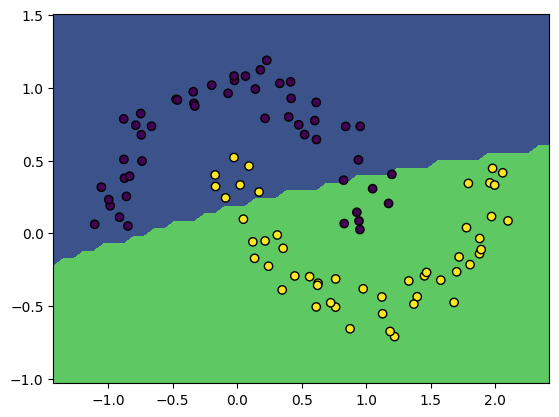

In [102]:
X, y = make_moons(100, noise=0.1)
model = QuadraticRegression(2)
gradient_descent(model, X, y, lr=3e-2, steps=250)

print('Model accuracy: %.3f' % model.accuracy(X, y))
plot_boundary(model, X, y)

#### **Q5:** Evaluating sin transforms

Repeat question 4, but using a different transform, defined as:

$$\phi(x_i) = \begin{bmatrix} x_i \\ \sin(10 x_i) \end{bmatrix}$$

### Answer

In [103]:
class SineRegression(LogisticRegression):
    def __init__(self, dims):
        # Multiply the number of dimensions for our weights by 2
        super().__init__(dims * 2)

    def prediction_function(self, X, w):
        '''
        Get the result of our base function for prediction (i.e. x^t w), 
        including a quadratic feature transform.

        Args:
            X (array): An N x d matrix of observations.
            w (array): A (d+1) x 1 vector of weights.
        Returns:
            pred (array): A length N vector of f(X).
        '''
        X = np.hstack([X, np.sin(10 * X)])
        X = np.pad(X, ((0,0), (0,1)), constant_values=1.)
        return np.dot(X, w)

Loss 24.89, accuracy: 0.86: 100%|██████████| 2500/2500 [00:01<00:00, 1773.91it/s]


Model accuracy: 0.860


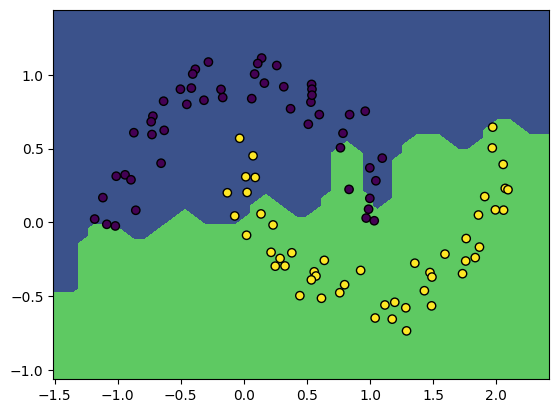

In [104]:
X, y = make_moons(100, noise=0.1)
model = SineRegression(2)
gradient_descent(model, X, y, lr=3e-2, steps=2500)

print('Model accuracy: %.3f' % model.accuracy(X, y))
plot_boundary(model, X, y)

#### **Q6:** Comparing feature transforms

Based on the results, would you use any feature transform for this problem? If so, which one?

### Answer

A basic feature transform does appear to help, but only slightly.

#### **Q7:** Creating your own transform
Repeat question 4, but define your own transform to try to get as close as you can to classifying all the points correctly. 

*This doesn't need to be perfect for full credit, just try to improve on the examples.*

$$\phi(x_i) = ?$$

### Answer

In [105]:
class MyRegression(LogisticRegression):
    def __init__(self, dims):
        # Multiply the number of dimensions for our weights by 2
        super().__init__(dims * 4)

    def prediction_function(self, X, w):
        '''
        Get the result of our base function for prediction (i.e. x^t w), 
        including a quadratic feature transform.

        Args:
            X (array): An N x d matrix of observations.
            w (array): A (d+1) x 1 vector of weights.
        Returns:
            pred (array): A length N vector of f(X).
        '''
        X = np.hstack([X, np.sin(X), np.cos(X), X ** 2])
        X = np.pad(X, ((0,0), (0,1)), constant_values=1.)
        return np.dot(X, w)

Loss 5.78, accuracy: 0.99: 100%|██████████| 2500/2500 [00:01<00:00, 1865.93it/s]


Model accuracy: 0.990


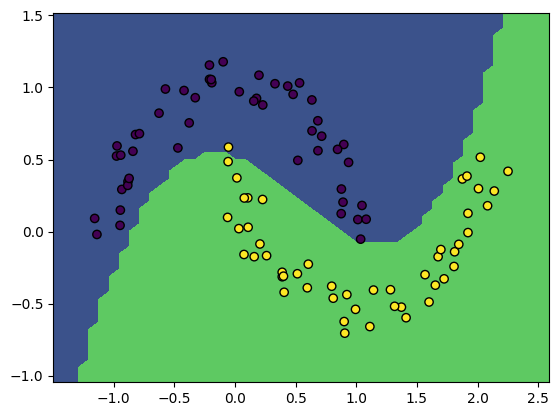

In [106]:
X, y = make_moons(100, noise=0.1)
model = MyRegression(2)
gradient_descent(model, X, y, lr=3e-2, steps=2500)

print('Model accuracy: %.3f' % model.accuracy(X, y))
plot_boundary(model, X, y)

## Part 3: Implementing a neural network

Now let's extend our model to be a neural network! We'll create a neural network class that extends our logistic regression class. First we'll setup the needed weight matrices.

#### **Q8:** Initializing a neural network
Fill in the Neural Network `__init__` method below. The method should take in the input data dimension and a list of integers specifying the size of each hidden layer (the number of neurons in each layer). The function should create a list of numpy arrays of the appropriate shapes for the weight matrices.

For example if `dims` is `2` and `hidden_sizes` is `[4, 4]`, then `self.weights` should have 3 entries of shapes `[(4x2), (4x4), (1x4)]`. This network is shown below (may not show in colab).

<div scale=0.5><svg xmlns="http://www.w3.org/2000/svg" style="cursor: move;" viewbox="100 100 1660 899" width="600" height="400"><g transform="translate(-1450.305465592915,-694.5417988897334) scale(2.441893025338307)"><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,469.5, 846.6666666666666,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,469.5, 846.6666666666666,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,469.5, 846.6666666666666,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,469.5, 846.6666666666666,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,509.5, 846.6666666666666,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,509.5, 846.6666666666666,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,509.5, 846.6666666666666,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M666.6666666666666,509.5, 846.6666666666666,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,429.5, 1026.6666666666667,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,429.5, 1026.6666666666667,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,429.5, 1026.6666666666667,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,469.5, 1026.6666666666667,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,469.5, 1026.6666666666667,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,469.5, 1026.6666666666667,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,509.5, 1026.6666666666667,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,509.5, 1026.6666666666667,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,509.5, 1026.6666666666667,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,549.5, 1026.6666666666667,429.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,549.5, 1026.6666666666667,469.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,549.5, 1026.6666666666667,509.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M1026.6666666666667,429.5, 1206.6666666666667,489.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M1026.6666666666667,469.5, 1206.6666666666667,489.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M1026.6666666666667,509.5, 1206.6666666666667,489.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,429.5, 1026.6666666666667,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,469.5, 1026.6666666666667,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,509.5, 1026.6666666666667,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M846.6666666666666,549.5, 1026.6666666666667,549.5"></path><path class="link" style="stroke-width: 0.5px; stroke-opacity: 1; stroke: rgb(80, 80, 80); fill: none;" marker-end="" d="M1026.6666666666667,549.5, 1206.6666666666667,489.5"></path><circle r="10" class="node" id="0_0" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="666.6666666666666" cy="469.5"></circle><circle r="10" class="node" id="0_1" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="666.6666666666666" cy="509.5"></circle><circle r="10" class="node" id="1_0" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="846.6666666666666" cy="429.5"></circle><circle r="10" class="node" id="1_1" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="846.6666666666666" cy="469.5"></circle><circle r="10" class="node" id="1_2" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="846.6666666666666" cy="509.5"></circle><circle r="10" class="node" id="1_3" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="846.6666666666666" cy="549.5"></circle><circle r="10" class="node" id="2_0" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="1026.6666666666667" cy="429.5"></circle><circle r="10" class="node" id="2_1" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="1026.6666666666667" cy="469.5"></circle><circle r="10" class="node" id="2_2" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="1026.6666666666667" cy="509.5"></circle><text class="text" dy=".35em" style="font-size: 12px;" x="631.6666666666666" y="589.5">Input Layer ∈ ℝ²</text><text class="text" dy=".35em" style="font-size: 12px;" x="811.6666666666666" y="589.5">Hidden Layer ∈ ℝ⁴</text><text class="text" dy=".35em" style="font-size: 12px;" x="991.6666666666667" y="589.5">Hidden Layer ∈ ℝ⁴</text><circle r="10" class="node" id="2_3" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="1026.6666666666667" cy="549.5"></circle><circle r="10" class="node" id="3_0" style="fill: rgb(255, 255, 255); stroke: rgb(51, 51, 51);" cx="1206.6666666666667" cy="489.5"></circle><text class="text" dy=".35em" style="font-size: 12px;" x="1171.6666666666667" y="589.5">Output Layer ∈ ℝ¹</text></g><defs><marker id="arrow" viewBox="0 -5 10 10" markerWidth="7" markerHeight="7" orient="auto" refX="40"><path d="M0,-5L10,0L0,5" style="stroke: rgb(80, 80, 80); fill: none;"></path></marker></defs></svg>

If you find it easier you could also define the weights in terms of $W^T$ instead, in which case the shapes would be: `[(2x4), (4x4), (4x1)]`. You could also consider how to add a bias term at each layer as in logistic regression (but this isn't nessecary for full credit).

The values in each array should be drawn from a normal distribution with standard deviation 1. You can create such a matrix in numpy using:

```
np.random.normal(scale=1., size=shape)
```

### Answer

In [107]:
class NeuralNetwork(LogisticRegression):
    def __init__(self, dims, hidden_sizes=[]):
        self.weights = [1. * np.random.normal(scale=1., size=(i + 1, o)) for (i, o) in zip([dims] + hidden_sizes, hidden_sizes + [1])]

test_nn_constructor(NeuralNetwork)

Passed!


Recall that for logistic regression the prediction function (before threholding or sigmoid) was $\mathbf{X}\mathbf{w}$. We now want to implement the prediction function for our neural network class. This function should perform the appropriate feature transforms and multiply by the regression weights. For a neural network with a single hidden layer this will look like:

$f(\mathbf{X}) = \sigma(\mathbf{X}\mathbf{W}_1^T)\mathbf{w}_0$

Use the **sigmoid** activation function for this problem.

For multiple layers we can also think of this a a **chain** of feature transforms:
$$\Phi_1 = \sigma(\mathbf{X}\mathbf{W}_1^T)$$
$$\Phi_2 = \sigma(\Phi_1 \mathbf{W}_2^T)$$
$$...$$
$$\Phi_l = \sigma(\Phi_{l-1} \mathbf{W}_l^T)$$
$$f(\mathbf{X}) = \Phi_l\mathbf{w}_0$$
Where $\Phi_i$ is just the variable that represents the neurons at layer $i$ (the result of the first $i$ transforms applied to $\mathbf{X}$).


#### **Q9:** Prediction function
Implement the prediction function as described above. Note that the prediction function should use the weights passed into the `w` argument rather than `self.weights`, this will make it easier to implement the next question.

***Hint:** Note that this function should **not** apply a final sigmoid or thresholding, instead it should be the equivalent of `linear_function` from the previous homework*


### Answer

In [108]:
def prediction_function(self, X, w):
    '''
    Get the result of our base function for prediction (i.e. x^t w)

    Args:
        X (array): An N x d matrix of observations.
        w (list of arrays): A list of weight matrices
    Returns:
        pred (array): An N x 1 matrix of f(X).
    '''
    for wi in w[:-1]:
        X = sigmoid(LogisticRegression.prediction_function(self, X, wi))
    pred = LogisticRegression.prediction_function(self, X, w[-1])
    return pred.reshape((-1, 1))

NeuralNetwork.prediction_function = prediction_function
test_nn_prediction_function(NeuralNetwork)

Passed!


#### **Q10:** Neural network loss
Implement an `nll_and_grad` method for the `NeuralNetwork` class using Autograd to compute the gradient with respect to each weight matrix.

***Hint:** If you use `np.pad` anywhere in your implementation, Autograd may complain if you don't include the keyword argument `mode='constant'`*

### Answer

In [109]:
def nll_and_grad(self, X, y):
    '''
    Get the negative log-likelihood loss and its gradient

    Args:
        X (array): An N x d matrix of observations.
        y (array): A length N vector of labels
    Returns:
        nll (float): The negative log-likelihood
        grads (list of arrays): A list of the gradient of the nll with respect
                                to each value in self.weights.
    '''
    loss = self.nll(X, y, self.weights)
    grads = grad(self.nll, argnum=2)(X, y, self.weights)
    return loss, grads

NeuralNetwork.nll_and_grad = nll_and_grad

We now have everything in place to train a neural network from scratch! Let's try it on our tiny dataset. Feel free to change the inputs.

***Hint**: If this give very poor results and/or runs very slowly, make sure to carefully check the shape of each operation in your code to make sure it matches your expectation.*

Loss 2.25, accuracy: 1.00: 100%|██████████| 250/250 [00:00<00:00, 1131.38it/s]  


Model accuracy: 1.000


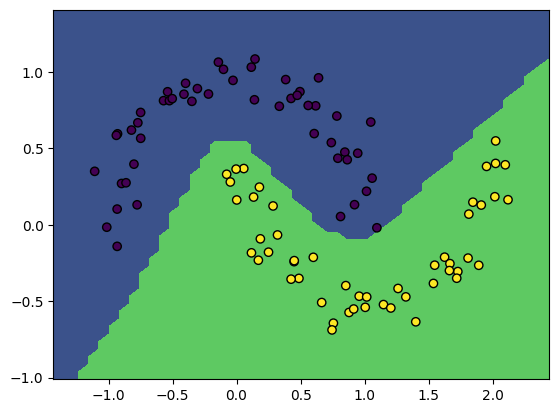

In [110]:
X, y = make_moons(100, noise=0.1)
model = NeuralNetwork(2, [5, 5])
gradient_descent(model, X, y, lr=3e-2, steps=250)

print('Model accuracy: %.3f' % model.accuracy(X, y))
plot_boundary(model, X, y)

#### **Q11:** Comparison

How does the neural network compare to explicit feature transforms in this case? How would you expect it to compare on other datasets?

### Answer

The neural network performed much better in this case, without needing to hand-design a transform!